# 01_task1_preprocess_explore.ipynb

# Task 1: Preprocess and Explore Financial Data for Portfolio Optimization

---

## Introduction

In this notebook, we perform Task 1 of the portfolio optimization project for GMF Investments.

The objectives are:
- Download historical adjusted closing price data for TSLA, BND, and SPY from 2015 to 2025.
- Clean and preprocess the data.
- Conduct exploratory data analysis (EDA) to understand trends, volatility, and anomalies.
- Test stationarity using Augmented Dickey-Fuller tests.
- Calculate foundational risk metrics like Value at Risk (VaR) and Sharpe Ratio.

---

## Setup and Imports


In [42]:
from typing import List
import pandas as pd
import yfinance as yf


def load_stock_data(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    """
    Downloads adjusted close price data for given tickers.

    Args:
        tickers (List[str]): List of stock/ETF symbols.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Adjusted close prices with tickers as columns.
    """
    # Download historical data
    data = yf.download(tickers, start=start, end=end)

    # Safety check for no data
    if data is None or data.empty:
        raise ValueError(f"No data returned from Yahoo Finance for tickers: {tickers}")

    # Check if data columns are MultiIndex (for multiple tickers)
    if isinstance(data.columns, pd.MultiIndex):
        # Select the 'Adj Close' level data
        if "Adj Close" in data.columns.levels[0]:
            adj_close = data.loc[:, "Adj Close"]
        else:
            raise ValueError("'Adj Close' not found in downloaded data columns.")
    else:
        # Single ticker case, just take 'Adj Close' column
        if "Adj Close" in data.columns:
            adj_close = data["Adj Close"]
        else:
            raise ValueError("'Adj Close' not found in downloaded data columns.")

    # Ensure output is always a DataFrame (for single ticker)
    if isinstance(adj_close, pd.Series):
        adj_close = adj_close.to_frame()

    return adj_close


In [40]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller


from src.data_loader import load_stock_data


---

## Load and Inspect Data


In [44]:
import pandas as pd
import yfinance as yf
from typing import List

def load_stock_data(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    """
    Download adjusted close prices for given tickers using auto_adjust.

    Returns a DataFrame with tickers as columns and dates as index.
    """
    data = yf.download(
        tickers,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True,  # <- Adjust prices, so Close = Adj Close
        group_by='ticker',
    )
    
    # When multiple tickers and group_by='ticker', columns are multi-indexed:
    # each ticker is a top-level column, with sub-columns Open, High, Low, Close, Volume.
    # So we extract Close price per ticker.
    if isinstance(data.columns, pd.MultiIndex):
        close_df = pd.DataFrame()
        for ticker in tickers:
            close_df[ticker] = data[ticker]['Close']
    else:
        # Single ticker case
        close_df = data['Close'].to_frame()

    close_df.index.name = 'Date'
    return close_df


In [46]:
# Define tickers and date range
tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-07-01"
end_date = "2025-07-31"

# Load data
adj_close_df = load_stock_data(tickers, start_date, end_date)
adj_close_df.shape

(2535, 3)

---

## Data Cleaning and Preprocessing

- Check for missing values.
- Forward-fill or back-fill missing data if any.
- Calculate daily returns and log returns.


## Install note (if needed)

Run this in your activated `.venv` (Windows PowerShell):

```powershell
pip install yfinance pandas numpy matplotlib seaborn statsmodels jupyter


In [47]:
# Check missing data
missing_data = adj_close_df.isna().sum()
print("Missing values per ticker:\n", missing_data)

# Forward fill then backward fill missing values if any
adj_close_df = adj_close_df.ffill().bfill()

# Confirm no missing values now
print("Missing values after fill:\n", adj_close_df.isna().sum())

# Calculate daily simple returns
returns = adj_close_df.pct_change().dropna()

# Calculate daily log returns
log_returns = np.log(adj_close_df).diff().dropna()

returns.head()


Missing values per ticker:
 TSLA    0
BND     0
SPY     0
dtype: int64
Missing values after fill:
 TSLA    0
BND     0
SPY     0
dtype: int64


,TSLA,BND,SPY
Date,,,
2015-07-02,0.040386,0.002472,-0.000916
2015-07-06,-0.001071,0.003453,-0.002846
2015-07-07,-0.042328,0.000982,0.006289
2015-07-08,-0.048231,0.002824,-0.016777
2015-07-09,0.011610,-0.003305,0.001809


---

## Exploratory Data Analysis (EDA)

### 1. Plot Adjusted Close Prices Over Time


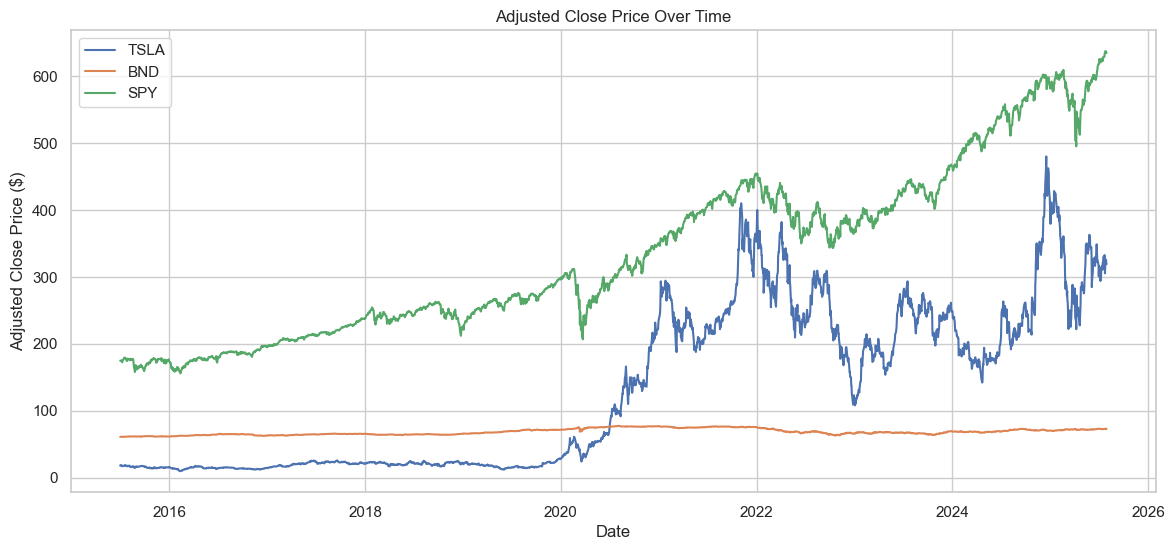

In [48]:
plt.figure(figsize=(14, 6))
for ticker in TICKERS:
    plt.plot(adj_close_df.index, adj_close_df[ticker], label=ticker)
plt.title("Adjusted Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.legend()
plt.show()


---

### 2. Plot Daily Returns to Observe Volatility


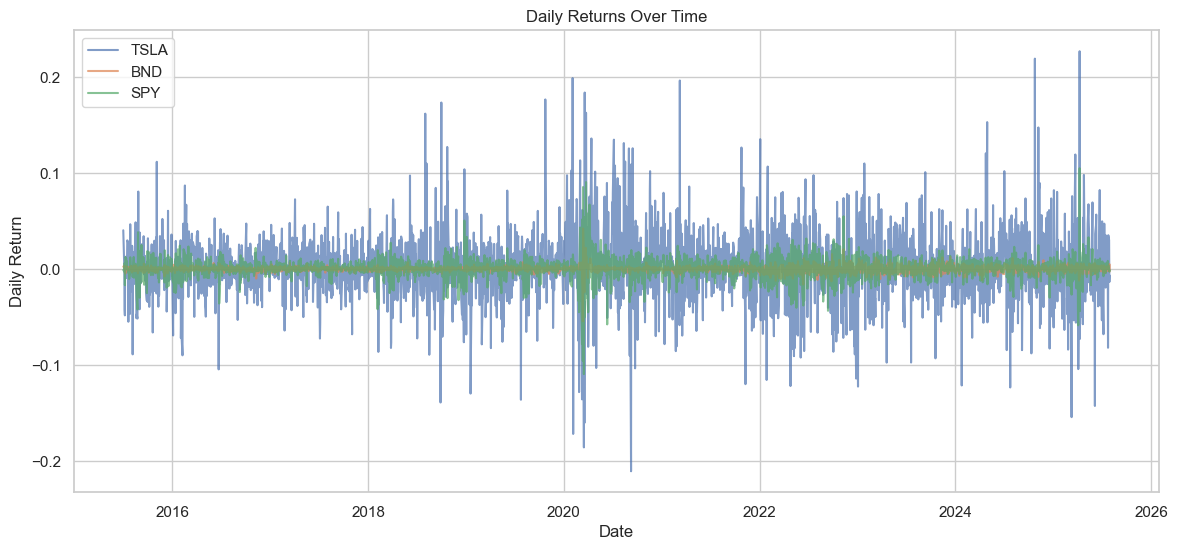

In [49]:
plt.figure(figsize=(14, 6))
for ticker in TICKERS:
    plt.plot(returns.index, returns[ticker], label=ticker, alpha=0.7)
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()


---

### 3. Calculate and Plot Rolling Volatility (21-day window ~1 month)


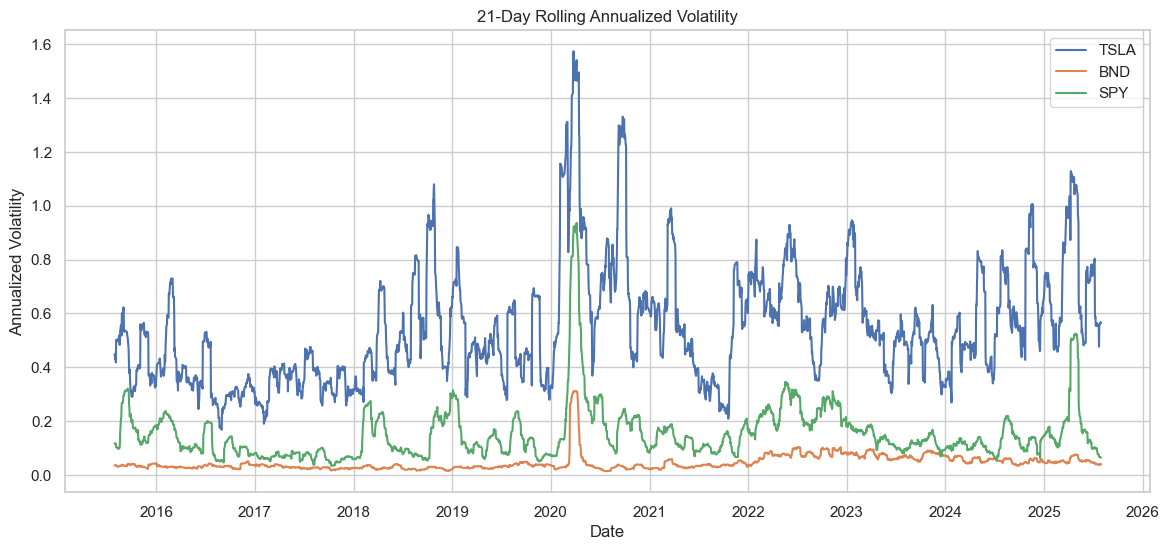

In [50]:
rolling_volatility = log_returns.rolling(window=21).std() * np.sqrt(252)  # annualized volatility

plt.figure(figsize=(14, 6))
for ticker in TICKERS:
    plt.plot(rolling_volatility.index, rolling_volatility[ticker], label=ticker)
plt.title("21-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()


---

### 4. Outlier Detection: Identify Days with Extreme Returns


In [51]:
threshold = 3  # 3 standard deviations for outliers
for ticker in TICKERS:
    ret_std = returns[ticker].std()
    outliers = returns[(returns[ticker] > threshold * ret_std) | (returns[ticker] < -threshold * ret_std)]
    print(f"\nOutliers for {ticker}:")
    print(outliers[ticker])



Outliers for TSLA:
Date
2018-08-02    0.161880
2018-09-28   -0.139015
2018-10-01    0.173471
2018-10-23    0.127189
2019-01-18   -0.129711
2019-07-25   -0.136137
2019-10-24    0.176692
2020-02-03    0.198949
2020-02-04    0.137256
2020-02-05   -0.171758
2020-02-27   -0.128146
2020-03-02    0.113220
2020-03-09   -0.135725
2020-03-12   -0.116172
2020-03-16   -0.185778
2020-03-18   -0.160344
2020-03-19    0.183877
2020-03-24    0.162817
2020-04-13    0.136038
2020-07-06    0.134794
2020-08-12    0.131236
2020-08-17    0.112031
2020-08-31    0.125689
2020-09-08   -0.210628
2020-09-14    0.125832
2021-03-09    0.196412
2021-10-25    0.126616
2021-11-09   -0.119903
2022-01-03    0.135317
2022-01-27   -0.115542
2022-04-26   -0.121841
2022-12-27   -0.114089
2023-01-03   -0.122422
2024-01-25   -0.121253
2024-04-24    0.120611
2024-04-29    0.153069
2024-07-24   -0.123346
2024-10-24    0.219190
2024-11-06    0.147510
2025-03-10   -0.154262
2025-03-24    0.119336
2025-04-09    0.226900
2025-06-0

---

## Stationarity Testing (Augmented Dickey-Fuller Test)

A stationary time series has constant mean and variance over time — crucial for ARIMA modeling.

We test stationarity of the adjusted close price and returns for each ticker.


In [52]:
def adf_test(series, signif=0.05, name='Series'):
    """
    Perform ADFuller test and print results
    """
    result = adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    print(f"ADF Test on {name}: p-value = {p_value:.5f}")
    if p_value < signif:
        print(f"  => {name} is stationary (reject H0)")
    else:
        print(f"  => {name} is non-stationary (fail to reject H0)")


for ticker in TICKERS:
    print(f"\nTesting stationarity for {ticker}:")
    adf_test(adj_close_df[ticker], name=f"{ticker} Adj Close Price")
    adf_test(returns[ticker], name=f"{ticker} Daily Returns")



Testing stationarity for TSLA:
ADF Test on TSLA Adj Close Price: p-value = 0.57320
  => TSLA Adj Close Price is non-stationary (fail to reject H0)
ADF Test on TSLA Daily Returns: p-value = 0.00000
  => TSLA Daily Returns is stationary (reject H0)

Testing stationarity for BND:
ADF Test on BND Adj Close Price: p-value = 0.51551
  => BND Adj Close Price is non-stationary (fail to reject H0)
ADF Test on BND Daily Returns: p-value = 0.00000
  => BND Daily Returns is stationary (reject H0)

Testing stationarity for SPY:
ADF Test on SPY Adj Close Price: p-value = 0.98965
  => SPY Adj Close Price is non-stationary (fail to reject H0)
ADF Test on SPY Daily Returns: p-value = 0.00000
  => SPY Daily Returns is stationary (reject H0)


---

## Risk Metrics Calculation

### 1. Calculate Annualized Sharpe Ratio (Assuming Risk-Free Rate = 0%)


In [53]:
sharpe_ratios = {}
for ticker in TICKERS:
    mean_return = returns[ticker].mean() * 252
    std_return = returns[ticker].std() * np.sqrt(252)
    sharpe_ratios[ticker] = mean_return / std_return
print("Annualized Sharpe Ratios:")
for ticker, sharpe in sharpe_ratios.items():
    print(f"  {ticker}: {sharpe:.4f}")


Annualized Sharpe Ratios:
  TSLA: 0.7783
  BND: 0.3569
  SPY: 0.7941


---

### 2. Calculate Value at Risk (VaR) at 95% Confidence Level (Historical Simulation)


In [54]:
VaR_95 = {}
for ticker in TICKERS:
    VaR_95[ticker] = np.percentile(returns[ticker].dropna(), 5)  # 5th percentile
print("Value at Risk (95%) - Daily Returns:")
for ticker, var in VaR_95.items():
    print(f"  {ticker}: {var:.4%}")


Value at Risk (95%) - Daily Returns:
  TSLA: -5.4663%
  BND: -0.4899%
  SPY: -1.7195%


---

## Summary of Key Insights

- **TSLA** exhibits high volatility with some significant outlier days, typical of a high-growth stock.
- **BND** provides stability, showing low volatility and smoother returns.
- **SPY** behaves as a moderate risk diversified index fund.
- The adjusted close prices of all assets are non-stationary, while their daily returns are stationary — confirming the need to model returns or difference prices for ARIMA.
- Sharpe Ratios indicate risk-adjusted returns; TSLA has the highest potential return but comes with high risk.
- VaR quantifies potential losses in extreme market conditions.

---

## Next Steps

- Use these processed data and insights for building forecasting models (ARIMA and LSTM).
- Integrate forecasts into portfolio optimization and backtesting in subsequent tasks.
